In [1]:
from matplotlib.collections import LineCollection
from matplotlib import pyplot as plt
from matplotlib import cm, colors
from sklearn.manifold import TSNE, MDS
from sklearn.decomposition import PCA
from hmmlearn import hmm
from tqdm import tqdm
import seaborn as sns
import pandas as pd
import numpy as np

import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

np.set_printoptions(linewidth=300, suppress=True)
pd.options.mode.chained_assignment = None  # default='warn'

from src.experiments.util_experiments import *
from src.oom import DiscreteValuedOOM, ContinuousValuedOOM
from src.oom.discrete_observable import DiscreteObservable
from src.oom.util.few_step_prediction import quantify_distribution, kl_divergence, mse, fix_pvec, get_discretized_operators
from src.oom.util.random_sparse import _generate_sparse_full_rank_matrix, _generate_observable_compound
from src.oom.util.learning_discrete import estimate_matrices_discrete_fixed
from src.oom.util.learning_continuous import estimate_matrices_continuous
from src.oom.util.numrank import numerical_rank_binomial, numerical_rank_frob_mid_spec

In [38]:
mflist = []
mflist.append(sp.stats.norm(loc=0, scale=1))
mflist.append(sp.stats.uniform(loc=0, scale=1))
mflist.append(sp.stats.uniform(loc=0.5, scale=0.5))
mflist.append(sp.stats.uniform(loc=3, scale=1))
mflist.append(sp.stats.uniform(loc=3, scale=2))

In [53]:
# Define the sources to be used
params = dict(
    lengths = [int(10 ** (k/2)) for k in range(2, 2+1)],
    test_len = 100,
    qdist_length = 5,
    len_ci_words = {
        2: 4,
        3: 3,
        4: 2,
        5: 2,
        6: 2
    }
)

qdintervals = [(-np.inf, 0), *[(a, a+1) for a in range(0, 9)], (10, np.inf)]

# Make source
case = "blended"
source_oom = make_source("S_5", case=case)
# source_oom = ContinuousValuedOOM.from_discrete_valued_oom(source_oom, mflist)
d0 = source_oom.dim
n0 = len(source_oom.observables)

lengths = [10]#params['lengths']
qdist_length = params['qdist_length']
len_ci_words = params['len_ci_words']
test_len = params['test_len']

# Generate sequence of the maximum length (all steps will be on subsequences)
# print(f"Generating {max(lengths) + test_len} observations")
gen = source_oom.generate(max(lengths) + test_len)
# print(f"Generating {max(lengths) + test_len} observations: Finished")

# Estimate entropy rate of source OOM on test data
# print(f"Computing source OOM entropy rate")
comp_source = source_oom.compute(gen.sequence_cont[-test_len:])
nll_source  = comp_source.nll_list[-1]
# print(f"Computing source OOM entropy rate: Finished, NLL_source = {nll_source}")

# Compute distribution of few-step prediction for source OOM
# print(f"Computing source OOM few-step prediction distribution at {qdist_length}-steps")
disc_ops_source = get_discretized_operators(source_oom, qdintervals)
fsp_vec_source = quantify_distribution(
    steps = qdist_length,
    state = source_oom.start_state,
    operators = list(disc_ops_source.values()),
    lin_func = source_oom.lin_func
)
fsp_vec_source = fix_pvec(fsp_vec_source)
print(f"Computing source OOM few-step prediction distribution at {qdist_length}-steps: Finished")

Computing source OOM few-step prediction distribution at 5-steps: Finished


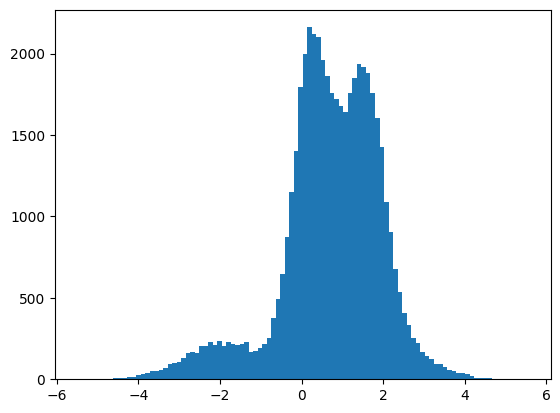

In [54]:
plt.hist(source_oom.generate(50000).sequence_cont, bins=100)
plt.show()

In [55]:
name = "S_3"
repetition = 0
lengths = [100, int(100*(10**0.5)), 1000, int(1000*(10**0.5)), 10000]
test_len = 50000

# Printers
pbarprint = PbarPrinter(
    indicator = name + f", rep_{repetition}",
    total = len(lengths),
    desc = f"{name:>10}, rep{repetition}: Experimental progress",
    position = 0,
    leave = False,
    file = sys.stdout
)

# Make source
case = "blended"
source_oom = make_source(name, case=case)
# source_oom = ContinuousValuedOOM.from_discrete_valued_oom(source_oom, mflist)
d0 = source_oom.dim
n0 = len(source_oom.observables)

_SOURCE_PARS = dict(case=case, name=name, d0=d0, n0=n0)			# Dict of stats

# Perform repetition
pbarprint(f"Repetition {repetition} started")

# Generate sequence of the maximum length (all steps will be on subsequences)
pbarprint(f"Generating {max(lengths) + test_len} observations")
gen = source_oom.generate(max(lengths) + test_len)
pbarprint(f"Generating {max(lengths) + test_len} observations: Finished")

# Estimate entropy rate of source OOM on test data
pbarprint(f"Computing source OOM entropy rate")
comp_source = source_oom.compute(gen.sequence_cont[-test_len:])
nll_source  = comp_source.nll_list[-1]
pbarprint(f"Computing source OOM entropy rate: Finished, NLL_source = {nll_source}")

# Compute distribution of few-step prediction for source OOM
pbarprint(f"Computing source OOM few-step prediction distribution at {qdist_length}-steps")
disc_ops_source = get_discretized_operators(source_oom, qdintervals)
fsp_vec_source = quantify_distribution(
    steps = qdist_length,
    state = source_oom.start_state,
    operators = list(disc_ops_source.values()),
    lin_func = source_oom.lin_func
)
fsp_vec_source = fix_pvec(fsp_vec_source)
pbarprint(f"Computing source OOM few-step prediction distribution at {qdist_length}-steps: Finished")

_SOURCE_METRICS = dict(repetition=repetition, nll_source=nll_source,
                       steps_fsp=qdist_length, fsp_source=fsp_vec_source)

for length in lengths:
    ##############################################
    # UNBLENDING WITH KNOWN MEMBERSHIP FUNCTIONS #
    ##############################################
    
    # Estimate large matrices with known membership functions
    cword_length = 2
    iword_length = 2
    pbarprint(f"Estimating matrices (BK) using L_c = {cword_length}, L_i = {iword_length} at length {length}")
    estimated_matrices = estimate_matrices_continuous(
        sequence             = gen.sequence_cont[:length],
        len_cwords           = cword_length,
        len_iwords           = iword_length,
        membership_functions = source_oom.membership_fns,
        observables          = source_oom.observables,
        ret_numrank          = True
    )
    rankmax = np.linalg.matrix_rank(estimated_matrices[0][0])
    ranknum = estimated_matrices[-1]
    estimated_matrices = estimated_matrices[:-1]
    pbarprint(f"Estimating matrices (BK) using L_c = {cword_length}, L_i = {iword_length} at length {length}: "
              f"Finished, rank(F_IJ) = {rankmax}, numrank(F_IJ) = {ranknum}")
    
    # d1_range = range(2, rankmax + 1)
    # d1_range = [x for x in range(ranknum-3, ranknum+3) if 2 <= x <= rankmax]
    d1_range = [x for x in range(2, 15) if 2 <= x <= rankmax]
    for d1 in d1_range:
        # Learn OOM using these parameters
        pbarprint(f"Learning")
        learned = ContinuousValuedOOM.from_data(
            gen.sequence_cont[:length],
            target_dimension     = d1,
            len_cwords           = cword_length,
            len_iwords           = iword_length,
            membership_functions = source_oom.membership_fns,
            observables          = source_oom.observables,
            estimated_matrices   = estimated_matrices
        )
        assert learned is not None, "OOM not learned"
        pbarprint(f"Learning: Finished")
        
        _LEARNED_PARS = dict(seqlength=length, cwlen=cword_length,
                             iwlen=iword_length, rankmax=rankmax,
                             ranknum=ranknum, d1=d1, n1=n0)
        
        # Estimate entropy rate of this learned OOM on test data
        pbarprint(f"Computing learned OOM entropy rate")
        with np.errstate(divide='ignore'):
            comp_learned = learned.compute(gen.sequence_cont[-test_len:])
        nll_learned = comp_learned.nll_list[-1]
        pbarprint(f"Computing learned OOM entropy rate: Finished, NLL_learned = {nll_learned}")
        
        # Compute distribution of few-step prediction for learned OOM
        pbarprint(f"Computing learned OOM few-step prediction distribution at {qdist_length}-steps")
        disc_ops_learned = get_discretized_operators(learned, qdintervals)
        fsp_vec_learned = quantify_distribution(
            steps = qdist_length,
            state = learned.start_state,
            operators = list(disc_ops_learned.values()),
            lin_func = learned.lin_func
        )
        fsp_vec_learned = fix_pvec(fsp_vec_learned)
        kldiv = kl_divergence(fsp_vec_source, fsp_vec_learned)
        mse_fsp = mse(fsp_vec_source, fsp_vec_learned)
        pbarprint(f"Computing learned OOM few-step prediction distribution at {qdist_length}-steps: "
                  f"Finished, KL(source, learned) = {kldiv}, MSE = {mse_fsp}")
        
        _LEARNED_METRICS = dict(nll_learned=nll_learned,
                                fsp_learned=fsp_vec_learned,
                                kl_divergence=kldiv,
                                mse=mse_fsp)
        
        # Save results for this learned OOM
        _SOURCE_PARS["case"] = _SOURCE_PARS["case"] + "_known"
        _HERE_RESULTS = dict(**_SOURCE_PARS, **_SOURCE_METRICS,
                             **_LEARNED_PARS, **_LEARNED_METRICS)
        # _RESULTS.append(_HERE_RESULTS)
        
        # Print results for this learned OOM
        pbarprint.update(1)
        with np.printoptions(legacy='1.21'):
            pbarprint(f"Results {without(_HERE_RESULTS, 'fsp_source', 'fsp_learned')}")
        
        _SOURCE_PARS["case"] = _SOURCE_PARS["case"].split('_')[0]

2025-04-17 20:30:31 | S_3, REP_0: Repetition 0 started                                                                 
2025-04-17 20:30:31 | S_3, REP_0: Generating 60000 observations                                                        
2025-04-17 20:30:38 | S_3, REP_0: Generating 60000 observations: Finished                                              
2025-04-17 20:30:38 | S_3, REP_0: Computing source OOM entropy rate                                                    
2025-04-17 20:30:42 | S_3, REP_0: Computing source OOM entropy rate: Finished, NLL_source = 2.2952534441545707         
2025-04-17 20:30:42 | S_3, REP_0: Computing source OOM few-step prediction distribution at 5-steps                     
2025-04-17 20:30:46 | S_3, REP_0: Computing source OOM few-step prediction distribution at 5-steps: Finished           
2025-04-17 20:30:46 | S_3, REP_0: Estimating matrices (BK) using L_c = 2, L_i = 2 at length 100                        
       S_3, rep0: Experimental progress:

100%|████████████████████████████████████████████████████████████████████████████████| 96/96 [00:00<00:00, 3320.22it/s]

0
[[0.00336829 0.0115691  0.00305812 0.0028238  0.002887   0.00183251 0.00245327 0.00051015 0.00109797]
 [0.00133543 0.00863436 0.00756765 0.00979566 0.00050423 0.00078659 0.00224425 0.00160273 0.00040909]
 [0.00285916 0.00301335 0.00198707 0.00248649 0.00019782 0.00071793 0.00105292 0.00126089 0.00033136]
 [0.00314612 0.00057701 0.00255184 0.00720424 0.00047622 0.0010397  0.00816803 0.00118316 0.00027648]
 [0.00017338 0.00160517 0.00070127 0.00151718 0.00037572 0.00139798 0.00056869 0.00008054 0.00021037]
 [0.00296349 0.00057814 0.00024906 0.00222224 0.00085432 0.00060962 0.0004507  0.00041157 0.00014102]
 [0.00365974 0.00252451 0.00084204 0.00559448 0.00022901 0.00130332 0.00265181 0.00042111 0.00027291]
 [0.00155753 0.00199496 0.00033841 0.00061346 0.00006004 0.00017911 0.00107698 0.00002951 0.0000351 ]
 [0.00060903 0.00103243 0.00014113 0.00040799 0.00078925 0.00027421 0.00021031 0.0002287  0.00006388]]
Oa
[[0.00000215 0.00134634 0.000724   0.00001783 0.00001245 0.00001831 0.001021

[[0.5993402  0.02356639 0.00372439]
 [0.02356639 0.6158234  0.11468665]
 [0.00372439 0.11468665 0.28198409]]
[[ 1.6710206  -0.06474015  0.00426015]
 [-0.06474015  1.75942529 -0.71472639]
 [ 0.00426015 -0.71472639  3.83693174]]
2025-04-17 20:30:52 | S_3, REP_0: Estimating matrices (BK) using L_c = 2, L_i = 2 at length 100: Finished, rank(F_IJ) = 9, numrank(F_IJ) = 1
2025-04-17 20:30:52 | S_3, REP_0: Learning                                                                             
2025-04-17 20:30:52 | S_3, REP_0: Learning: Finished                                                                   
2025-04-17 20:30:52 | S_3, REP_0: Computing learned OOM entropy rate                                                   
2025-04-17 20:30:56 | S_3, REP_0: Computing learned OOM entropy rate: Finished, NLL_learned = 2.3972665336745234       
2025-04-17 20:30:56 | S_3, REP_0: Computing learned OOM few-step prediction distribution at 5-steps                    
2025-04-17 20:30:59 | S_3, REP_0

100%|██████████████████████████████████████████████████████████████████████████████| 312/312 [00:00<00:00, 1612.51it/s]


0
[[0.00190441 0.00624776 0.00223588 0.00216186 0.00244671 0.00140214 0.00219197 0.00129151 0.00087473]
 [0.00294064 0.00918788 0.004724   0.00756934 0.00060052 0.00106305 0.00194591 0.00191717 0.00074168]
 [0.00178756 0.00437272 0.00162214 0.00219363 0.00058038 0.00065537 0.00065688 0.00110275 0.00030006]
 [0.008606   0.00113909 0.00213679 0.00657484 0.00190178 0.00199023 0.00491834 0.00094629 0.00075353]
 [0.00037841 0.00242826 0.00105767 0.00313898 0.00158534 0.00080208 0.00136045 0.00066889 0.00022798]
 [0.00192027 0.00139599 0.00087111 0.00182755 0.00079318 0.00037639 0.0003687  0.00031972 0.00009343]
 [0.00291356 0.00207717 0.00075623 0.00410132 0.00072517 0.00085526 0.00150417 0.00046986 0.00030361]
 [0.00076555 0.00145596 0.00074416 0.00224224 0.00072953 0.00021122 0.00107322 0.00057067 0.00009263]
 [0.00071485 0.00058416 0.0002204  0.0006709  0.00067789 0.00023774 0.00025079 0.00026225 0.00005425]]
Oa
[[0.00009493 0.00063786 0.0006308  0.00013619 0.000403   0.000451   0.000470

100%|██████████████████████████████████████████████████████████████████████████████| 996/996 [00:00<00:00, 3503.72it/s]


0
[[0.00306738 0.00677821 0.00212513 0.00524379 0.00226797 0.00103526 0.00169515 0.00158505 0.0007185 ]
 [0.00461865 0.00847858 0.00366803 0.00489045 0.00371396 0.00172252 0.00171166 0.00216281 0.00074178]
 [0.00184617 0.00358783 0.00157462 0.00137846 0.00141225 0.00070981 0.00055651 0.00102631 0.00030986]
 [0.00678142 0.00448292 0.00279184 0.00946887 0.00198024 0.00182418 0.00379494 0.00067279 0.00057036]
 [0.00234478 0.00194721 0.00068819 0.00263239 0.00086515 0.00060207 0.0020091  0.00076389 0.00023719]
 [0.00166821 0.00136152 0.00065737 0.00203824 0.00077175 0.00048532 0.00080525 0.0003587  0.0001297 ]
 [0.00216275 0.00209396 0.00086155 0.00428726 0.00082481 0.00066376 0.00141645 0.00046479 0.00025325]
 [0.00127459 0.00203521 0.00061093 0.0018172  0.00063765 0.00027586 0.00093255 0.00061022 0.00013293]
 [0.00049903 0.00071241 0.00022285 0.00071021 0.00049506 0.00020673 0.0003664  0.00023724 0.00006707]]
Oa
[[0.00067465 0.00246308 0.00061943 0.00092936 0.00064782 0.00025732 0.000309

100%|████████████████████████████████████████████████████████████████████████████| 3158/3158 [00:00<00:00, 3526.20it/s]


0
[[0.00298819 0.00574259 0.00218762 0.00462283 0.00252149 0.00128949 0.0018651  0.00142664 0.00052146]
 [0.00477975 0.00963296 0.0032762  0.00475212 0.0042058  0.00235137 0.00168402 0.00191824 0.00076825]
 [0.00176035 0.00317156 0.00120419 0.00157362 0.00143826 0.00087337 0.00051805 0.00085894 0.00029024]
 [0.00616405 0.00399992 0.00239582 0.00900278 0.0033269  0.00185904 0.00348639 0.0009405  0.00042902]
 [0.00339914 0.00366716 0.00099444 0.00383173 0.00247993 0.00102202 0.00175814 0.0010617  0.00029155]
 [0.00160849 0.00153692 0.00060916 0.00260878 0.0011791  0.00067755 0.00090956 0.00036939 0.00015392]
 [0.00199882 0.00228853 0.00075049 0.0035941  0.00140062 0.00067717 0.00126766 0.00066288 0.00020721]
 [0.00141321 0.00241272 0.00051407 0.00173272 0.00098436 0.00036635 0.0008506  0.00053993 0.00011979]
 [0.00045148 0.00067701 0.00018193 0.00065955 0.00042782 0.0001731  0.00028972 0.00019356 0.00005274]]
Oa
[[0.00053792 0.001686   0.00068146 0.0009709  0.0007984  0.00042289 0.000399

100%|████████████████████████████████████████████████████████████████████████████| 9996/9996 [00:02<00:00, 3359.84it/s]


0
[[0.00414263 0.00649725 0.00218392 0.00499216 0.00258745 0.00141624 0.00185841 0.00155024 0.00051121]
 [0.00501299 0.00987466 0.00334624 0.00488753 0.00426531 0.0025319  0.00175213 0.00210337 0.00084581]
 [0.00187451 0.00347952 0.00130839 0.00165914 0.00143249 0.00083329 0.00057005 0.00082452 0.00027226]
 [0.0065882  0.00462668 0.00229402 0.00931322 0.00257153 0.00183753 0.00367169 0.00093502 0.00050828]
 [0.00314492 0.00264418 0.00097443 0.00415366 0.00163311 0.00075744 0.00171634 0.00078852 0.00027433]
 [0.0015443  0.00134012 0.00057154 0.00252127 0.00080088 0.00056392 0.00093625 0.00031901 0.00016281]
 [0.00207881 0.00254318 0.0008166  0.00345387 0.00119769 0.0005414  0.00131254 0.00065986 0.00020668]
 [0.00148143 0.00193861 0.00057259 0.00176388 0.000997   0.00035076 0.00074134 0.00047538 0.00012627]
 [0.00055829 0.00059806 0.00019879 0.00074508 0.00033568 0.00015793 0.00029998 0.00014413 0.0000484 ]]
Oa
[[0.00105527 0.00179918 0.00060219 0.00120655 0.00069086 0.0004072  0.000430

In [60]:
import json
import re
results = []
with open('tmp_res_3.txt') as f:
    for line in f:
        if rgx_match := re.search("Results {(.)+}", line):
            res = rgx_match.group(0)[8:].replace("\'", "\"")
            res_dict = json.loads(res)
            results.append(res_dict)
res = pd.DataFrame.from_records(results)
res['nll_diff'] = res['nll_learned'] - res['nll_source']
res = res[res['repetition'] < 16]
res

,case,name,d0,n0,repetition,nll_source,steps_fsp,seqlength,cwlen,iwlen,rankmax,ranknum,d1,n1,nll_learned,kl_divergence,mse,nll_diff
0,blended_known,S_3,10,3,0,2.295253,5,100,2,2,9,1,2,3,2.397267,0.055408,0.003825,0.102013
1,blended_known,S_3,10,3,0,2.295253,5,100,2,2,9,1,3,3,4.331646,13.613019,0.030138,2.036393
2,blended_known,S_3,10,3,0,2.295253,5,100,2,2,9,1,4,3,3.531877,0.776431,0.005084,1.236623
3,blended_known,S_3,10,3,0,2.295253,5,100,2,2,9,1,5,3,3.199442,0.305010,0.000577,0.904188
4,blended_known,S_3,10,3,0,2.295253,5,100,2,2,9,1,6,3,3.720024,2.397234,0.003974,1.424771
5,blended_known,S_3,10,3,0,2.295253,5,100,2,2,9,1,7,3,4.128591,9.097239,0.009311,1.833337
6,blended_known,S_3,10,3,0,2.295253,5,100,2,2,9,1,8,3,4.229688,11.830512,0.021327,1.934435
7,blended_known,S_3,10,3,0,2.295253,5,100,2,2,9,1,9,3,3.751042,2.351447,0.002252,1.455789
8,blended_known,S_3,10,3,0,2.295253,5,316,2,2,9,1,2,3,2.429497,0.053197,0.001812,0.134244
9,blended_known,S_3,10,3,0,2.295253,5,316,2,2,9,1,3,3,2.341972,0.031675,0.000387,0.046718


In [61]:
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np

def plot_nlld(res: pd.DataFrame, source: str, case: str, ax, col: str=None):
    # Filter results by source name and experiment case, group by training data length, aggregate by regular statistics
    grouped = res.query(f"name=='{source}' & case=='{case}'").groupby(['seqlength'])[['nll_diff']].agg(['min', 'mean', 'std', 'max']).reset_index()

    # Plot min, max, mean+-std
    ax.plot(grouped['seqlength'], grouped['nll_diff']['min'], c=col, ls='--', label='min/max')
    ax.plot(grouped['seqlength'], grouped['nll_diff']['max'], c=col, ls='--')
    ax.plot(grouped['seqlength'], grouped['nll_diff']['mean'], c=col, label='mean/std')
    ax.fill_between(grouped['seqlength'],
                    grouped['nll_diff']['mean'] - grouped['nll_diff']['std'],
                    grouped['nll_diff']['mean'] + grouped['nll_diff']['std'], color=col, alpha=0.2)
    
    ax.set_xscale('log')
    ax.set_xlim([grouped['seqlength'].min(), grouped['seqlength'].max()])
    ax.set_xlabel('Training sequence length')
    
    if "gmm" not in case: ax.set_ylabel(r'$\Delta \hat{H}$')
    try:
        title_app = f" ({case.split("_")[1]} memberships)"
    except IndexError:
        title_app = ''
    ax.set_title(f'NLL Difference' + title_app)
    ax.legend(loc='upper right')

def plot_kl(res: pd.DataFrame, source: str, case: str, ax, col: str=None):
    grouped = res.query(f"name=='{source}' & case=='{case}'").groupby(['seqlength'])[['kl_divergence']].agg([
        ('min', 'min'),
        ('q25', lambda x: x.quantile(0.25)),
        ('median', 'median'),
        ('q75', lambda x: x.quantile(0.75)),
        ('max', 'max')
    ]).reset_index()
    
    ax.plot(grouped['seqlength'], grouped['kl_divergence']['min'], c=col, ls='--', label='min/max')
    ax.plot(grouped['seqlength'], grouped['kl_divergence']['max'], c=col, ls='--')
    ax.plot(grouped['seqlength'], grouped['kl_divergence']['median'], c=col, label='q25 to q75')
    ax.fill_between(grouped['seqlength'],
                    grouped['kl_divergence']['q25'],
                    grouped['kl_divergence']['q75'], color=col, alpha=0.2)
    
    ax.set_xscale('log')
    ax.set_xlim([grouped['seqlength'].min(), grouped['seqlength'].max()])
    ax.set_xlabel('Training sequence length')

    ylims = ax.get_ylim()
    ax.set_ylim([0, ylims[1]])
    if "gmm" not in case: ax.set_ylabel(r'$KL$')

    try:
        title_app = f" ({case.split("_")[1]} memberships)"
    except IndexError:
        title_app = ''
    ax.set_title(f'KL Divergence' + title_app)
    ax.legend(loc='upper right')

def plot_gmm_nll(res: pd.DataFrame, source: str, ax, col: str=None):
    grouped = res.query(f"name=='{source}' & case=='blended_gmm'").groupby(['seqlength'])[['nll_gmm', 'l2_gmm']].agg(['min', 'mean', 'std', 'max']).reset_index()

    col = 'red'
    ax.plot(grouped['seqlength'], grouped['nll_gmm']['min'], c=col, ls='--', label='min/max')
    ax.plot(grouped['seqlength'], grouped['nll_gmm']['max'], c=col, ls='--')
    ax.plot(grouped['seqlength'], grouped['nll_gmm']['mean'], c=col, label='mean/std')
    ax.fill_between(grouped['seqlength'],
                    grouped['nll_gmm']['mean'] - grouped['nll_gmm']['std'],
                    grouped['nll_gmm']['mean'] + grouped['nll_gmm']['std'], color=col, alpha=0.2)
    
    ax.set_xscale('log')
    ax.set_xlim([grouped['seqlength'].min(), grouped['seqlength'].max()])
    ax.set_xlabel('Training sequence length')

    ylims = ax.get_ylim()
    # ax.set_ylim([0, ylims[1]])
    ax.set_ylabel(r'$NLL$')
    
    ax.set_title(f'NLL for best GMM')
    ax.legend(loc='upper right')

def plot_gmm_l2(res: pd.DataFrame, source: str, ax, col: str=None):
    grouped = res.query(f"name=='{source}' & case=='blended_gmm'").groupby(['seqlength'])[['nll_gmm', 'l2_gmm']].agg(['min', 'mean', 'std', 'max']).reset_index()

    col = 'royalblue'
    ax.plot(grouped['seqlength'], grouped['l2_gmm']['min'], c=col, ls='--', label='min/max')
    ax.plot(grouped['seqlength'], grouped['l2_gmm']['max'], c=col, ls='--')
    ax.plot(grouped['seqlength'], grouped['l2_gmm']['mean'], c=col, label='mean/std')
    ax.fill_between(grouped['seqlength'],
                    grouped['l2_gmm']['mean'] - grouped['l2_gmm']['std'],
                    grouped['l2_gmm']['mean'] + grouped['l2_gmm']['std'], color=col, alpha=0.2)
    
    ax.set_xscale('log')
    ax.set_xlim([grouped['seqlength'].min(), grouped['seqlength'].max()])
    ax.set_xlabel('Training sequence length')

    ylims = ax.get_ylim()
    ax.set_ylim([0, ylims[1]])
    ax.set_ylabel(r'$L^2$')
    
    ax.set_title(f'L2 for best GMM')
    ax.legend(loc='upper right')

def plot_best_minmaxmeansd(res_best: pd.DataFrame, name: str, case: str, target: str, col: str=None, ax=None):
    try:
        title_app = f"{case.split("_")[1]}"
    except IndexError:
        title_app = case
    
    bch = res_best.query(f"name=='{name}' & case=='{case}'").reset_index(level='seqlength', drop=False)
    ax.plot(bch['seqlength'], bch[(target, 'mean')], c=col)
    ax.fill_between(bch['seqlength'],
                    bch[(target, 'mean')] - bch[(target, 'std')],
                    bch[(target, 'mean')] + bch[(target, 'std')],
                    alpha=0.1, color=col,
                    label=f"${name}$ {title_app}")
    ax.set_xscale('log')
    ax.set_xlim([bch['seqlength'].min(), bch['seqlength'].max()])
    ax.set_xlabel('Training sequence length')
    
    ax.set_ylabel(target)
    ylims = ax.get_ylim()
    ax.set_ylim([
        min(bch[(target, 'min')].min(), ylims[0]),
        max(bch[(target, 'max')].max(), ylims[1])
    ])

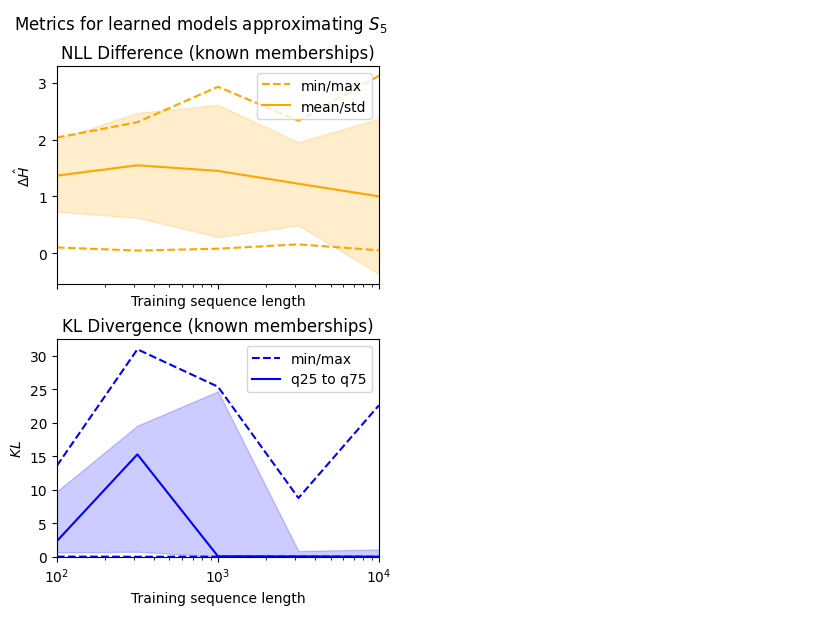

In [62]:
fig = plt.figure(figsize=(8, 6), layout='constrained')
subfigs = fig.subfigures(1, 2, wspace=0.05)
subfigs = subfigs.flatten()

axs = subfigs[0].subplots(2, 1, sharex='all', gridspec_kw=dict(hspace=0.0))
axs = axs.flatten()
subfigs[0].suptitle(r'Metrics for learned models approximating $S_5$')
plot_nlld(res, 'S_3', 'blended_known', axs[0], col='orange')
plot_kl(res, 'S_3', 'blended_known', axs[1], col='blue')

# axs = subfigs[1].subplots(2, 1, sharex='all', gridspec_kw=dict(hspace=0.0))
# axs = axs.flatten()
# subfigs[1].suptitle(r'Metrics for learned models approximating $S_5$')
# plot_nlld(res, 'S_5', 'blended_known', axs[0], col='orange')
# plot_kl(res, 'S_5', 'blended_known', axs[1], col='blue')

# plt.savefig('mf/blendedCONTROL_many.pdf')
plt.show()